In [74]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from rdflib import Graph
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms import bipartite
from datetime import datetime

In [75]:
dep = pd.read_csv('data/final_dep_18.csv')
dep['id'] = dep['id'].astype(str)

In [76]:
vot_1 = pd.read_csv('data/votazione-08-02-18.csv')
vot_1.columns = ['votazione', 'titolo', 'descrizione', 'numeroVotazione', 'cognome',
       'nome', 'voto_1', 'infoAssenza', 'deputato'] #change name of the columns 'Espressione' in a meaningful one
#extract id from the link
a = []
for i in range(vot_1.shape[0]):
    a.append(vot_1['deputato'][i][40:46])

vot_1['id'] = a
vot_1.drop('deputato', inplace= True, axis = 1)

merged = pd.merge(dep[['Parlamentare', 'id', 'Partito']], vot_1[['id', 'voto_1']], how = 'left') #first merge


In [77]:
vot_3 = pd.read_csv('data/votazione-03-08-22.csv')
vot_3.columns = ['votazione', 'titolo', 'descrizione', 'numeroVotazione', 'cognome',
       'nome', 'voto_3', 'infoAssenza', 'deputato'] #change name of the columns 'Espressione' in a meaningful one
#extract id from the link
a = []
for i in range(vot_3.shape[0]):
    a.append(vot_3['deputato'][i][40:46])

vot_3['id'] = a
vot_3.drop('deputato', inplace= True, axis = 1)

merged = pd.merge(merged, vot_3[['id', 'voto_3']], how = 'left') #first merge



In [78]:
merged

,Parlamentare,id,Partito,voto_1,voto_3
0,BASINI GIUSEPPE,200049,(LEGA),Non ha votato,Non ha votato
1,BERSANI PIER LUIGI,300026,(MISTO),Favorevole,Non ha votato
2,LETTA ENRICO,300127,(PD),Favorevole,Non ha votato
3,MINNITI DOMENICO,300146,(PD),NaN,NaN
4,FRANCESCHINI DARIO,300246,(PD),Non ha votato,Non ha votato
...,...,...,...,...,...
655,GIORGETTI GIANCARLO,50115,(LEGA),NaN,NaN
656,PAROLO UGO,50123,(LEGA),NaN,NaN
657,FOTI TOMMASO,50204,(FDI),NaN,NaN
658,RUSSO PAOLO,50213,(FI),NaN,NaN


In [79]:
np.unique(vot_1['voto_1'], return_counts= True)

(array(['Astensione', 'Contrario', 'Favorevole', 'Non ha votato'],
       dtype=object),
 array([  6,   1, 467, 154]))

In [80]:
sum([  6,   1, 467, 154])

628

In [81]:
import missingno as msno

<Axes: >

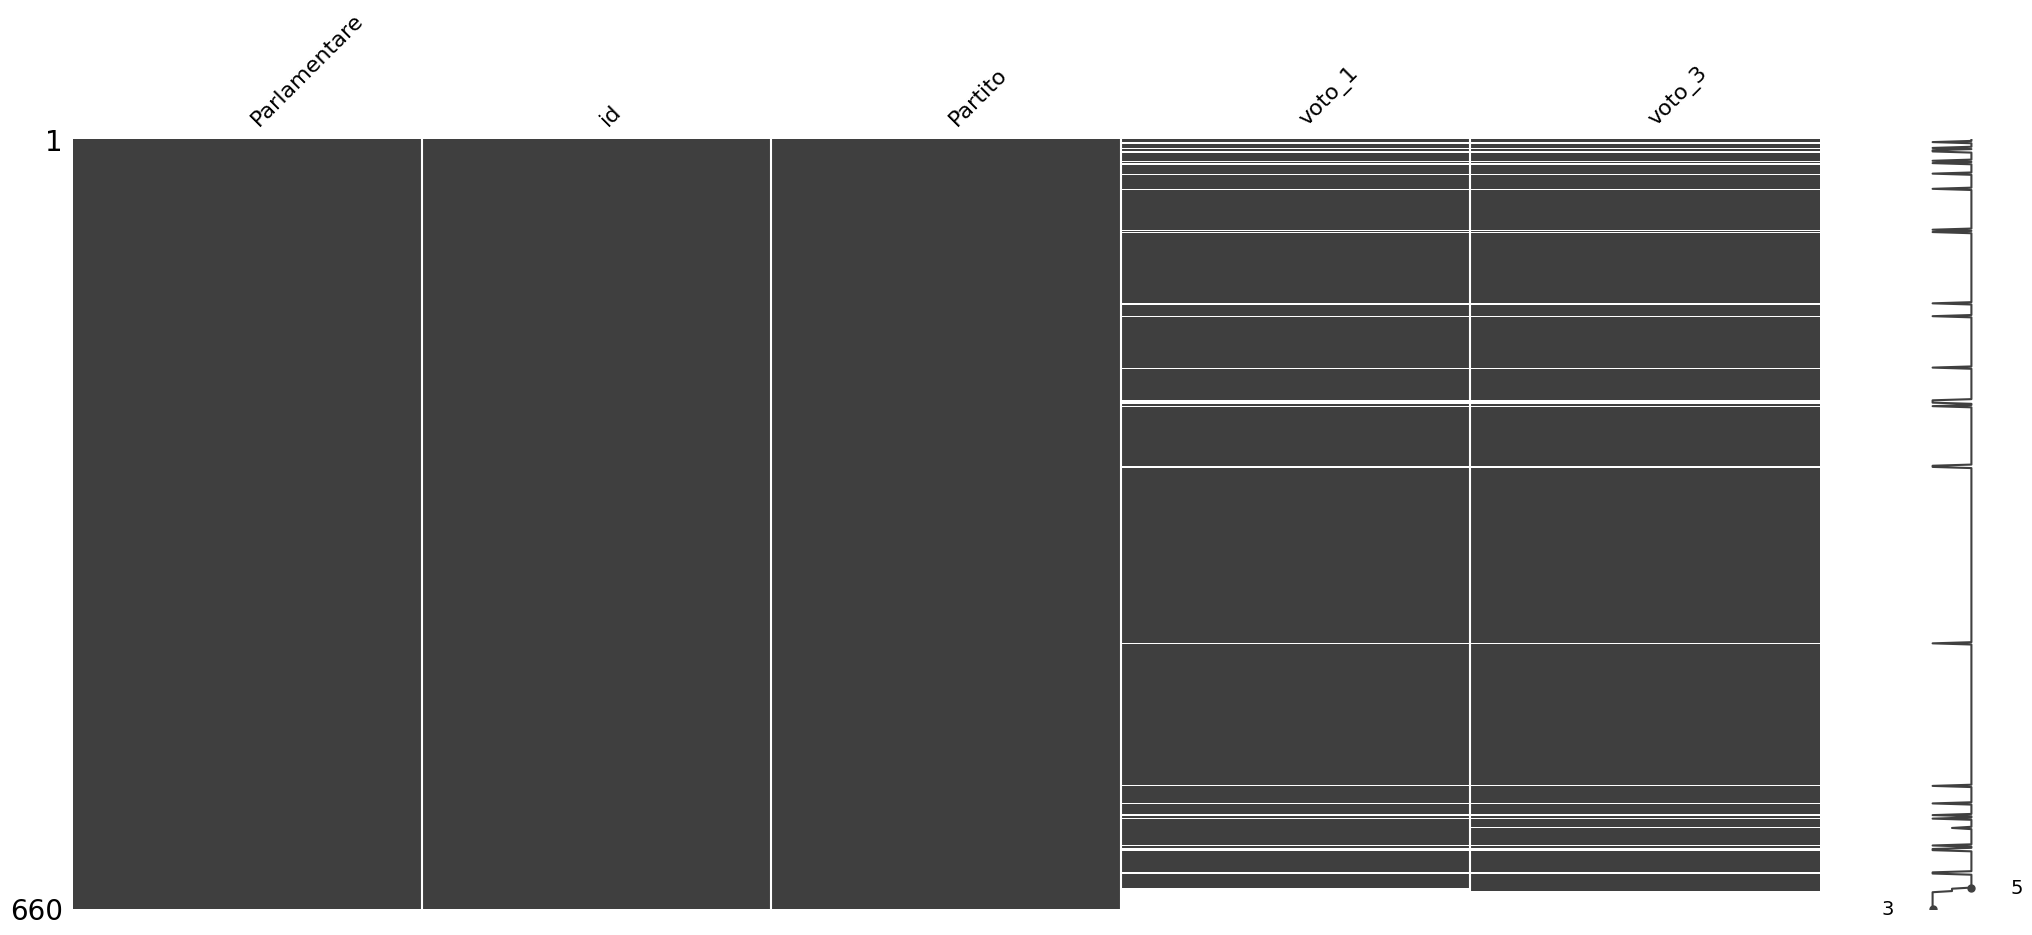

In [82]:
msno.matrix(merged)

In [83]:
merged.fillna('Assente', inplace= True)
print(np.unique(merged['voto_1']))
#np.unique(merged['voto_3'])

['Assente' 'Astensione' 'Contrario' 'Favorevole' 'Non ha votato']


In [84]:
dizionario_espressioni = {'Favorevole' : '1', 'Contrario': '-1', 'Assente': '0', 'Astensione': '2', 'In missione': '0', 'Non ha votato': '0'}
merged['voto_1'] = merged['voto_1'].map(dizionario_espressioni)
merged['voto_3'] = merged['voto_3'].map(dizionario_espressioni)

In [85]:
merged

,Parlamentare,id,Partito,voto_1,voto_3
0,BASINI GIUSEPPE,200049,(LEGA),0,0
1,BERSANI PIER LUIGI,300026,(MISTO),1,0
2,LETTA ENRICO,300127,(PD),1,0
3,MINNITI DOMENICO,300146,(PD),0,0
4,FRANCESCHINI DARIO,300246,(PD),0,0
...,...,...,...,...,...
655,GIORGETTI GIANCARLO,50115,(LEGA),0,0
656,PAROLO UGO,50123,(LEGA),0,0
657,FOTI TOMMASO,50204,(FDI),0,0
658,RUSSO PAOLO,50213,(FI),0,0


In [86]:
np.unique(merged['id'], return_counts= True)

(array(['200049', '300026', '300127', '300146', '300246', '300271',
        '300296', '300299', '300306', '300319', '300328', '300356',
        '300387', '300439', '300447', '300453', '300480', '300497',
        '300506', '300637', '300674', '301056', '301436', '301448',
        '301449', '301452', '301455', '301457', '301459', '301463',
        '301465', '301477', '301500', '301531', '301533', '301541',
        '301559', '301561', '301573', '302089', '302103', '302124',
        '302151', '302155', '302164', '302744', '302754', '302759',
        '302762', '302764', '302770', '302774', '302782', '302783',
        '302789', '302794', '302824', '302832', '302838', '302854',
        '302856', '302863', '302867', '302872', '302875', '302881',
        '302882', '302886', '302891', '302892', '302909', '302913',
        '302914', '302942', '302943', '302949', '302964', '302968',
        '302969', '302980', '302983', '302995', '303038', '303108',
        '303110', '303200', '304521', '304601', 

In [101]:
m = np.array(merged)
m[0, 3:]
voti_dep1 = m[0, 3:]
voti_dep2 = m[1, 3:]

In [103]:
print(voti_dep1)

['0' '0']


In [ ]:
numero_votazioni = 2  #numero di leggi che prendiamo in considerazione

def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2)) # volte in cui hanno votato la stessa cosa
entrambi_assenti = np.sum((voti_dep1 == voti_dep2) == (voti_dep1 == 0)) # volte in cui non hanno votato entrambi

In [102]:
uguali = np.sum((voti_dep1 == voti_dep2)) # volte in cui hanno votato la stessa cosa
entrambi_assenti = np.sum((voti_dep1 == voti_dep2) == (voti_dep1 == 0)) # volte in cui non hanno votato entrambi
numero_totale_votazioni = 2
sim = uguali/(numero_totale_votazioni-entrambi_assenti)


1